# 03_07_challenge - Planetary conjunctions

In [1]:
import numpy as np
import matplotlib.pyplot as pp

import numba

import astropy.constants
import astropy.time
import astropy.coordinates

import scipy.integrate
import scipy.interpolate
import scipy.optimize

In [2]:
bodies = ['sun','mercury','venus','earth','mars','jupiter','saturn','uranus','neptune']

massdict = {'sun': 1.0,
            'mercury': 1.6601209949637026e-07,
            'venus': 2.4478382857373332e-06,
            'earth': 3.0034896946063695e-06,
            'mars': 3.227156037857755e-07,
            'jupiter': 0.0009547918983127075,
            'saturn': 0.00028588567008942334,
            'uranus': 4.3662495719438076e-05,
            'neptune': 5.151383713179197e-05}

masses = np.array([massdict[body] for body in bodies])

In [3]:
G = astropy.constants.G.to('AU^3 / (Msun d^2)').value

In [4]:
@numba.jit
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)**1.5
    
    return yd

In [5]:
def get_posvel(body, t):
    posvel = astropy.coordinates.get_body_barycentric_posvel(body, t)
    
    return np.hstack([posvel[0].xyz.value.T, posvel[1].xyz.value.T])

In [6]:
t0, t1 = astropy.time.Time('2021-07-04'), astropy.time.Time('2031-07-04')

/home/miguel/anaconda3/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [7]:
y0 = np.array([get_posvel(body, t0) for body in bodies]).flatten()

In [8]:
def get_orbits(y):
    return scipy.integrate.solve_ivp(ydot, [t0.mjd, t1.mjd], y, rtol=1e-9, atol=1e-9)

In [9]:
orbits = get_orbits(y0)

In [10]:
orbint = scipy.interpolate.interp1d(orbits.t, orbits.y)

In [14]:
orbint(t0.mjd)

array([-7.77940195e-03,  4.34017341e-03,  2.03704144e-03, -5.37208312e-06,
       -6.78869467e-06, -2.74086332e-06,  3.36477212e-01, -1.44331518e-01,
       -1.13065987e-01,  7.64683753e-03,  2.34128294e-02,  1.17147635e-02,
       -7.05529604e-01,  1.42792324e-01,  1.08481574e-01, -4.87851687e-03,
       -1.81284422e-02, -7.84836656e-03,  2.02987462e-01, -9.08236814e-01,
       -3.93560929e-01,  1.65489414e-02,  3.20200963e-03,  1.38765895e-03,
       -1.48108634e+00,  6.94567945e-01,  3.58383718e-01, -5.99579632e-03,
       -1.02388807e-02, -4.53432074e-03,  4.00222927e+00, -2.76183300e+00,
       -1.28120815e+00,  4.47340372e-03,  5.88774592e-03,  2.41491048e-03,
        6.25437708e+00, -7.04987571e+00, -3.18137407e+00,  4.01771778e-03,
        3.28490808e-03,  1.18343119e-03,  1.48700780e+01,  1.19723452e+01,
        5.03304942e+00, -2.61268197e-03,  2.52830320e-03,  1.14446928e-03,
        2.95461566e+01, -4.03578501e+00, -2.38731664e+00,  4.59208334e-04,
        2.88331279e-03,  

In [15]:
help(np.sqrt)

Help on ufunc:

sqrt = <ufunc 'sqrt'>
    sqrt(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Return the non-negative square-root of an array, element-wise.
    
    Parameters
    ----------
    x : array_like
        The values whose square-roots are required.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out` array will retain its original value.
        Note that if an uninitialized `out` array is 

In [22]:
def get_cos(t, body1, body2, orbint):
    # get position of all bodies at time t
    y = orbint(t)
    
    # compute indices of each body
    i, j = bodies.index(body1), bodies.index(body2)
    k = bodies.index('earth')
    
    # compute cosinus of tetha distance
    return np.sqrt(np.sum((y[i*6:i*6+3] - y[k*6:k*6+3]) * (y[j*6:j*6+3] - y[k*6:k*6+3]), axis=0))

In [23]:
ts = astropy.time.Time('2021-07-04').mjd + np.arange(0, 10*365)

/tmp/ipykernel_201/1478599690.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum((y[i*6:i*6+3] - y[k*6:k*6+3]) * (y[j*6:j*6+3] - y[k*6:k*6+3]), axis=0))


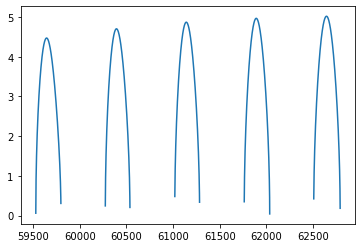

In [31]:
pp.plot(ts, get_cos(ts, 'mars', 'saturn', orbint))

In [32]:
for x0 in [59700,60400,61250,61900,62600]:
    minimum = scipy.optimize.minimize(lambda t: -get_cos(t, 'mars', 'saturn', orbint), x0=x0, bounds=[(ts[0],ts[-1])])
    print(minimum.x, minimum.fun)

[59645.19643758] [-4.47210388]
[60393.91440124] [-4.70428762]
[61141.89845125] [-4.87090465]
[61891.30817969] [-4.96812671]
[62644.74000994] [-5.02070874]
